In [1]:
import sys
import importlib
import subprocess

def install_if_colab():
    if "google.colab" in sys.modules:
        print("Running in Google Colab. Checking required libraries...")

        packages = ["moabb", "braindecode","torch_geometric"]  # Add required libraries
        missing_packages = [pkg for pkg in packages if importlib.util.find_spec(pkg) is None]

        if missing_packages:
            print(f"Installing missing libraries: {', '.join(missing_packages)}")
            !pip install {" ".join(missing_packages)}
        else:
            print("All required libraries are already installed.")
    else:
        print("Not running in Google Colab. No installation needed.")

install_if_colab()


Running in Google Colab. Checking required libraries...
All required libraries are already installed.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pickle
with open(path+'EEG_data/test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

import pickle
with open(path+'EEG_data/train_set.pkl', 'rb') as f:
    train_set = pickle.load(f)

In [4]:
import torch
#from shallow_fbcsp import ShallowFBCSPNet
from braindecode.util import set_random_seeds


cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 91111
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = 22
input_window_samples = 1125

print("n_classes: ", n_classes)
print("n_channels:", n_channels)
print("input_window_samples size:", input_window_samples)

n_classes:  4
n_channels: 22
input_window_samples size: 1125


/usr/local/lib/python3.11/dist-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


In [22]:
#from models_fbscp import CollapsedShallowNet
# The ShallowFBCSPNet is a `nn.Sequential` model
import importlib
import RGNN
importlib.reload(RGNN)
from RGNN import ShallowRGNNNet
from CKA_functions import adjacency_matrix_motion,adjacency_matrix_distance_motion
adj_m,pos = adjacency_matrix_motion()
#print(adj_m)
adj_dis_m, dm = adjacency_matrix_distance_motion(pos,delta=5)
dm
torch_tensor = torch.from_numpy(dm)
edge_weight = torch_tensor.reshape(-1).to(device)
print(edge_weight.shape)

model = ShallowRGNNNet(22,4,1125,edge_weight)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model.cuda()



torch.Size([484])
ShallowRGNNNet(
  (temporal): Conv2d(1, 10, kernel_size=(1, 25), stride=(1, 1))
  (rgnn): SimpleGCNNet(
    (rgnn): SGConv(55, 20, K=1)
  )
  (batch_norm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=(1, 20), stride=(1, 20), padding=0)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=4400, out_features=4, bias=True)
)


In [23]:
# splitted = windows_dataset.split("session")
# train_set = splitted['0train']  # Session train
# test_set = splitted['1test']  # Session evaluation

from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader

#lr = 1e-4
#weight_decay = 1e-4
#batch_size = 64
#n_epochs = 200


In [24]:
#train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))


#from collections import defaultdict

#counting_dict = defaultdict(int)  # Initialize class counter

#for batch_idx, (X, y, _) in progress_bar:
#   X, y = X.to(device), y.to(device)  # Move to device if needed

    # Count occurrences of each class in y
#    for value in y:
#        counting_dict[int(value.item())] += 1  # Convert tensor to int and update count

# Print class frequencies
#print("Class counts:", dict(counting_dict))


In [25]:

from tqdm import tqdm
# Define a method for training one epoch


def train_one_epoch(
        dataloader: DataLoader, model: Module,edge_index, loss_fn, optimizer,
        scheduler: LRScheduler, epoch: int, device, print_batch_stats=True
):
    model.train()  # Set the model to training mode
    train_loss, correct = 0, 0

    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader),
                        disable=not print_batch_stats)

    for batch_idx, (X, y, _) in progress_bar:
        X, y = X.to(device), y.to(device)
        #print(y)
        #print(X.shape)
        optimizer.zero_grad()
        pred = model(X,edge_index)


        #print(y.shape)
        #print(pred.shape)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()  # update the model weights
        optimizer.zero_grad()
        #print(loss.item())
        #print(loss)
        #print(train_loss)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()

        #if print_batch_stats:
        #    progress_bar.set_description(
        #        f"Epoch {epoch}/{n_epochs}, "
        #        f"Batch {batch_idx + 1}/{len(dataloader)}, "
        #        f"Loss: {loss.item():.6f}"
        #    )

    # Update the learning rate
    scheduler.step()

    correct /= len(dataloader.dataset)
    return train_loss / len(dataloader), correct


In [26]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

@torch.no_grad()
def test_model(dataloader: DataLoader, model: torch.nn.Module,edge_index, loss_fn, print_batch_stats=True):
    device = next(model.parameters()).device  # Get model device
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    model.eval()  # Switch to evaluation mode
    test_loss, correct = 0, 0

    # Initialize dictionaries for per-class tracking
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    # Lists to store true and predicted labels for confusion matrix
    all_preds = []
    all_targets = []

    if print_batch_stats:
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    else:
        progress_bar = enumerate(dataloader)

    for batch_idx, (X, y, _) in progress_bar:
        X, y = X.to(device), y.to(device)
        pred = model(X,edge_index)
        batch_loss = loss_fn(pred, y).item()

        test_loss += batch_loss
        correct += (pred.argmax(1) == y).sum().item()

        # Store predictions and true labels for confusion matrix
        all_preds.append(pred.argmax(1).cpu())
        all_targets.append(y.cpu())

        # Compute per-class accuracy
        preds_labels = pred.argmax(1)
        for label, pred_label in zip(y, preds_labels):
            class_total[label.item()] += 1
            class_correct[label.item()] += (label == pred_label).item()

        if print_batch_stats:
            progress_bar.set_description(
                f"Batch {batch_idx + 1}/{len(dataloader)}, Loss: {batch_loss:.6f}"
            )

    # Convert lists to tensors
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Compute per-class accuracy
    class_accuracies = {
        cls: (class_correct[cls] / class_total[cls]) * 100 if class_total[cls] > 0 else 0
        for cls in class_total
    }

    # Compute overall accuracy
    test_loss /= n_batches
    overall_accuracy = (correct / size) * 100

    # Print per-class accuracy
    print("\nClass-wise Accuracy:")
    for cls, acc in class_accuracies.items():
        print(f"  Class {cls}: {acc:.2f}%")

    print(f"Test Accuracy: {overall_accuracy:.1f}%, Test Loss: {test_loss:.6f}\n")

    return test_loss, overall_accuracy, class_accuracies, all_preds, all_targets


In [27]:
import wandb
wandb.login()

True

In [28]:
threshold = 0  # Adjust as needed

source_nodes = []
target_nodes = []

# Iterate over all elements in the distance matrix, including self-loops and duplicates
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):  # Iterate over all pairs, including (i, i)
        if dm[i, j] >= threshold:  # If the distance meets the condition
            source_nodes.append(i)  # Source node
            target_nodes.append(j)  # Target node

# Create the edge_index tensor
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long).to(device)

Epoch 1/100: 

Batch 81/81, Loss: 1.163162: 100%|██████████| 81/81 [00:00<00:00, 82.65it/s]



Class-wise Accuracy:
  Class 1: 49.85%
  Class 2: 52.78%
  Class 0: 40.43%
  Class 3: 56.17%
Test Accuracy: 49.8%, Test Loss: 1.275230


Class-wise Accuracy:
  Class 1: 49.85%
  Class 2: 52.78%
  Class 0: 40.43%
  Class 3: 56.17%
Train Accuracy: 73.42%, Average Train Loss: 0.681562, Test Accuracy: 49.81%, Average Test Loss: 1.275230

Epoch 2/100: 

Batch 81/81, Loss: 1.282117: 100%|██████████| 81/81 [00:00<00:00, 86.39it/s]



Class-wise Accuracy:
  Class 1: 54.94%
  Class 2: 49.38%
  Class 0: 42.59%
  Class 3: 54.94%
Test Accuracy: 50.5%, Test Loss: 1.265061


Class-wise Accuracy:
  Class 1: 54.94%
  Class 2: 49.38%
  Class 0: 42.59%
  Class 3: 54.94%
Train Accuracy: 72.30%, Average Train Loss: 0.686929, Test Accuracy: 50.46%, Average Test Loss: 1.265061

Epoch 3/100: 

Batch 81/81, Loss: 1.202457: 100%|██████████| 81/81 [00:01<00:00, 72.71it/s]



Class-wise Accuracy:
  Class 1: 54.48%
  Class 2: 46.60%
  Class 0: 45.83%
  Class 3: 54.01%
Test Accuracy: 50.2%, Test Loss: 1.281990


Class-wise Accuracy:
  Class 1: 54.48%
  Class 2: 46.60%
  Class 0: 45.83%
  Class 3: 54.01%
Train Accuracy: 73.38%, Average Train Loss: 0.667057, Test Accuracy: 50.23%, Average Test Loss: 1.281990

Epoch 4/100: 

Batch 81/81, Loss: 1.282191: 100%|██████████| 81/81 [00:01<00:00, 78.52it/s]



Class-wise Accuracy:
  Class 1: 54.01%
  Class 2: 52.78%
  Class 0: 45.68%
  Class 3: 52.93%
Test Accuracy: 51.4%, Test Loss: 1.271335


Class-wise Accuracy:
  Class 1: 54.01%
  Class 2: 52.78%
  Class 0: 45.68%
  Class 3: 52.93%
Train Accuracy: 73.92%, Average Train Loss: 0.675713, Test Accuracy: 51.35%, Average Test Loss: 1.271335

Epoch 5/100: 

Batch 81/81, Loss: 1.255804: 100%|██████████| 81/81 [00:00<00:00, 87.85it/s]



Class-wise Accuracy:
  Class 1: 52.16%
  Class 2: 53.86%
  Class 0: 43.83%
  Class 3: 52.62%
Test Accuracy: 50.6%, Test Loss: 1.250348


Class-wise Accuracy:
  Class 1: 52.16%
  Class 2: 53.86%
  Class 0: 43.83%
  Class 3: 52.62%
Train Accuracy: 72.38%, Average Train Loss: 0.673602, Test Accuracy: 50.62%, Average Test Loss: 1.250348

Epoch 6/100: 

Batch 81/81, Loss: 1.314824: 100%|██████████| 81/81 [00:00<00:00, 83.40it/s]



Class-wise Accuracy:
  Class 1: 52.93%
  Class 2: 57.72%
  Class 0: 41.36%
  Class 3: 54.48%
Test Accuracy: 51.6%, Test Loss: 1.269212


Class-wise Accuracy:
  Class 1: 52.93%
  Class 2: 57.72%
  Class 0: 41.36%
  Class 3: 54.48%
Train Accuracy: 74.27%, Average Train Loss: 0.650275, Test Accuracy: 51.62%, Average Test Loss: 1.269212

Epoch 7/100: 

Batch 81/81, Loss: 1.325657: 100%|██████████| 81/81 [00:00<00:00, 85.68it/s]



Class-wise Accuracy:
  Class 1: 53.09%
  Class 2: 54.78%
  Class 0: 44.14%
  Class 3: 53.86%
Test Accuracy: 51.5%, Test Loss: 1.289420


Class-wise Accuracy:
  Class 1: 53.09%
  Class 2: 54.78%
  Class 0: 44.14%
  Class 3: 53.86%
Train Accuracy: 74.04%, Average Train Loss: 0.649809, Test Accuracy: 51.47%, Average Test Loss: 1.289420

Epoch 8/100: 

Batch 81/81, Loss: 1.198772: 100%|██████████| 81/81 [00:00<00:00, 82.89it/s]



Class-wise Accuracy:
  Class 1: 52.16%
  Class 2: 53.55%
  Class 0: 40.59%
  Class 3: 56.48%
Test Accuracy: 50.7%, Test Loss: 1.251991


Class-wise Accuracy:
  Class 1: 52.16%
  Class 2: 53.55%
  Class 0: 40.59%
  Class 3: 56.48%
Train Accuracy: 74.42%, Average Train Loss: 0.651818, Test Accuracy: 50.69%, Average Test Loss: 1.251991

Epoch 9/100: 

Batch 81/81, Loss: 1.210790: 100%|██████████| 81/81 [00:01<00:00, 73.14it/s]



Class-wise Accuracy:
  Class 1: 48.61%
  Class 2: 57.25%
  Class 0: 41.82%
  Class 3: 59.26%
Test Accuracy: 51.7%, Test Loss: 1.267081


Class-wise Accuracy:
  Class 1: 48.61%
  Class 2: 57.25%
  Class 0: 41.82%
  Class 3: 59.26%
Train Accuracy: 75.35%, Average Train Loss: 0.646039, Test Accuracy: 51.74%, Average Test Loss: 1.267081

Epoch 10/100: 

Batch 81/81, Loss: 1.239807: 100%|██████████| 81/81 [00:00<00:00, 85.08it/s]



Class-wise Accuracy:
  Class 1: 49.69%
  Class 2: 54.17%
  Class 0: 48.15%
  Class 3: 54.17%
Test Accuracy: 51.5%, Test Loss: 1.236640


Class-wise Accuracy:
  Class 1: 49.69%
  Class 2: 54.17%
  Class 0: 48.15%
  Class 3: 54.17%
Train Accuracy: 73.23%, Average Train Loss: 0.670327, Test Accuracy: 51.54%, Average Test Loss: 1.236640

Epoch 11/100: 

Batch 81/81, Loss: 1.146081: 100%|██████████| 81/81 [00:00<00:00, 83.87it/s]



Class-wise Accuracy:
  Class 1: 47.99%
  Class 2: 52.31%
  Class 0: 43.06%
  Class 3: 60.34%
Test Accuracy: 50.9%, Test Loss: 1.260084


Class-wise Accuracy:
  Class 1: 47.99%
  Class 2: 52.31%
  Class 0: 43.06%
  Class 3: 60.34%
Train Accuracy: 75.31%, Average Train Loss: 0.634455, Test Accuracy: 50.93%, Average Test Loss: 1.260084

Epoch 12/100: 

Batch 81/81, Loss: 1.200403: 100%|██████████| 81/81 [00:00<00:00, 87.87it/s]



Class-wise Accuracy:
  Class 1: 54.17%
  Class 2: 46.14%
  Class 0: 49.38%
  Class 3: 54.78%
Test Accuracy: 51.1%, Test Loss: 1.264986


Class-wise Accuracy:
  Class 1: 54.17%
  Class 2: 46.14%
  Class 0: 49.38%
  Class 3: 54.78%
Train Accuracy: 73.19%, Average Train Loss: 0.649761, Test Accuracy: 51.12%, Average Test Loss: 1.264986

Epoch 13/100: 

Batch 81/81, Loss: 1.204537: 100%|██████████| 81/81 [00:00<00:00, 85.67it/s]



Class-wise Accuracy:
  Class 1: 53.86%
  Class 2: 49.38%
  Class 0: 48.77%
  Class 3: 51.70%
Test Accuracy: 50.9%, Test Loss: 1.266840


Class-wise Accuracy:
  Class 1: 53.86%
  Class 2: 49.38%
  Class 0: 48.77%
  Class 3: 51.70%
Train Accuracy: 73.88%, Average Train Loss: 0.656761, Test Accuracy: 50.93%, Average Test Loss: 1.266840

Epoch 14/100: 

Batch 81/81, Loss: 1.193247: 100%|██████████| 81/81 [00:01<00:00, 75.67it/s]



Class-wise Accuracy:
  Class 1: 53.70%
  Class 2: 51.23%
  Class 0: 46.45%
  Class 3: 56.79%
Test Accuracy: 52.0%, Test Loss: 1.273465


Class-wise Accuracy:
  Class 1: 53.70%
  Class 2: 51.23%
  Class 0: 46.45%
  Class 3: 56.79%
Train Accuracy: 74.96%, Average Train Loss: 0.635876, Test Accuracy: 52.04%, Average Test Loss: 1.273465

Epoch 15/100: 

Batch 81/81, Loss: 1.198380: 100%|██████████| 81/81 [00:01<00:00, 68.93it/s]



Class-wise Accuracy:
  Class 1: 51.70%
  Class 2: 54.78%
  Class 0: 44.29%
  Class 3: 55.56%
Test Accuracy: 51.6%, Test Loss: 1.260623


Class-wise Accuracy:
  Class 1: 51.70%
  Class 2: 54.78%
  Class 0: 44.29%
  Class 3: 55.56%


KeyboardInterrupt: 

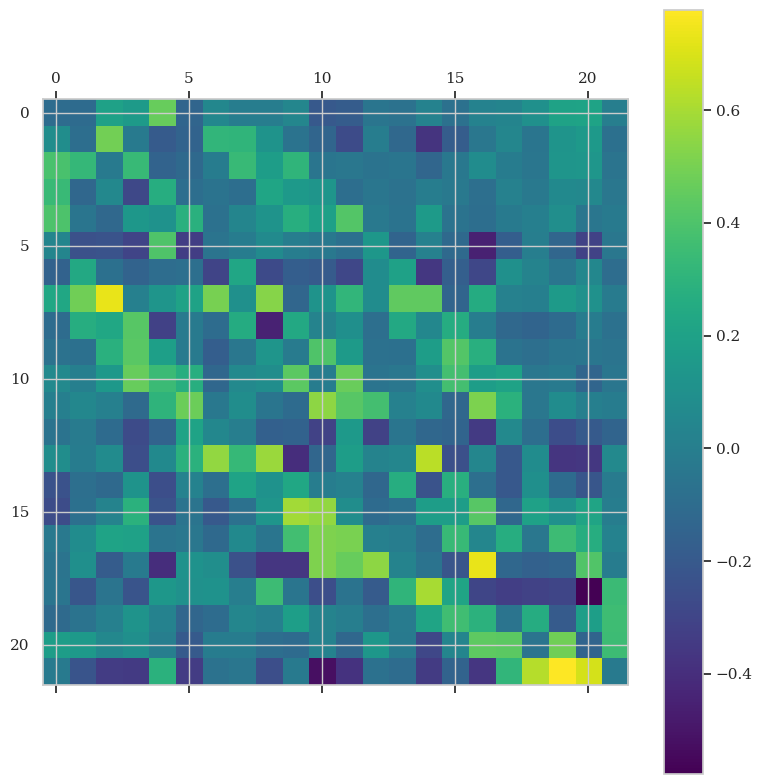

In [32]:
import torch
import wandb
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import CrossEntropyLoss
import numpy as np
import matplotlib.pyplot as plt

# Initialize Weights & Biases
wandb.init(project="Master Thesis", name=f"RGNN {seed}")

# Define hyperparameters
lr = 1e-3
weight_decay = 1e-4
batch_size = 32  # Start with 124
n_epochs = 100

final_acc = 0.0

# Log hyperparameters to wandb
wandb.config.update({
    "learning_rate": lr,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
    "epochs": n_epochs
})

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 1)

# Define loss function
loss_fn = CrossEntropyLoss()

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

# Initialize lists to store all predictions & targets
all_preds, all_targets = [], []
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


# Training loop
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}: ", end="")

    train_loss, train_accuracy = train_one_epoch(
        train_loader, model,edge_index, loss_fn, optimizer, scheduler, epoch, device
    )

    test_loss, test_accuracy, class_accuracies, batch_preds, batch_targets = test_model(test_loader, model,edge_index, loss_fn)
    final_acc = test_accuracy

    # Store predictions & labels for confusion matrix
    all_preds.extend(batch_preds)
    all_targets.extend(batch_targets)

    # Print class-wise accuracy
    print("\nClass-wise Accuracy:")
    for class_idx, acc in class_accuracies.items():
        print(f"  Class {class_idx}: {acc:.2f}%")

    adj_matrix = model.rgnn.edge_weights.detach().cpu().numpy().reshape(22,22)

    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(adj_matrix, cmap='viridis', interpolation='nearest')  # Adjust color map
    fig.colorbar(cax)

    # Save the adjacency matrix as an image (not as a graph)
    plt.tight_layout()
    img_path = f"adj_matrix_epoch_{epoch}.png"
    plt.savefig(img_path)
    plt.close()

    # Log results to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy * 100,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "learning_rate": scheduler.get_last_lr()[0],
        **{f"class_{class_idx}_accuracy": acc for class_idx, acc in class_accuracies.items()},
        "adj_matrix": wandb.Image(img_path),
    })

    print(
        f"Train Accuracy: {100 * train_accuracy:.2f}%, "
        f"Average Train Loss: {train_loss:.6f}, "
        f"Test Accuracy: {test_accuracy:.2f}%, "
        f"Average Test Loss: {test_loss:.6f}\n"
    )

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Save predictions & true labels for later use (confusion matrix)
wandb.log({"all_preds": all_preds.tolist(), "all_targets": all_targets.tolist()})



In [ ]:
wandb.finish()

In [ ]:
import math
# Assuming 'model' is your trained Braindecode model
print(seed)
torch.save(model, f"RGNN_{math.ceil(final_acc)}_{seed}.pth")
torch.save(model.state_dict(), f"RGNN_{math.ceil(final_acc)}_{seed}_state.pth")
